In [10]:
import time
import os
import pickle
from pathlib import Path
import json
from typing import List, Optional
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

import xgboost as xgb

import optuna
from optuna.visualization.matplotlib import (plot_param_importances, plot_contour, plot_optimization_history,
                                            plot_slice, plot_parallel_coordinate, plot_rank)
from optuna.integration import PyTorchLightningPruningCallback
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [2]:
SEED = 440

DIR = os.getcwd()
TRAIN_FEATURES_PATH = DIR + "/data" + "/train_features_X4juyT6.csv"
TRAIN_LABELS_PATH = DIR + "/data" + "/train_labels_JxtENGl.csv"
XGB_TUNING_DIR = DIR + "/tuning" + "/xgb"

# encoded paths
DBERTA_CME_PATH = DIR + "/data" + "/cme_deberta_enc.npy"
GTE_CME_PATH = DIR + "/data" + "/cme_gte_enc.npy"
GTE_LE_PATH = DIR + "/data" + "/le_gte_enc.npy"

In [3]:
train_features_df = pd.read_csv(TRAIN_FEATURES_PATH)
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

In [5]:
def save_study_charts(study: optuna.study,
                      study_name: str,
                      dir: str) -> None:

    # save charts of trials
    fig = plt.figure(figsize=(8,8))
    plot_optimization_history(study)
    plt.savefig(f"{dir}/{study_name}_opt_hist.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_parallel_coordinate(study)
    plt.savefig(f"{dir}/{study_name}_parallel_coord.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_param_importances(study)
    plt.savefig(f"{dir}/{study_name}_param_importances.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_rank(study)
    plt.savefig(f"{dir}/{study_name}_rank.png")

    plt.clf()
    fig = plt.figure()
    plot_slice(study)
    plt.savefig(f"{dir}/{study_name}_slice.png")

In [6]:
def split_data(text_df, 
               labels_df,
               test_perc=0.15, 
               val_perc=0.15, 
               test_seed=42, 
               val_seed=74) -> tuple[pd.DataFrame]:
    
    val_size = int(len(text_df) * val_perc)
    X_tr, X_te, y_tr, y_te = train_test_split(text_df, labels_df, test_size=test_perc, shuffle=True, 
                                             random_state=test_seed, stratify=labels_df)
    #val_perc = val_size // len(X_tr)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=val_size, shuffle=True,
                                               random_state=val_seed, stratify=y_tr)
    
    #y_tr_sub, y_val_sub, y_te_sub = y_tr[features], y_val[features], y_te[features]
    
    return X_tr, X_val, X_te, y_tr, y_val, y_te

#### Load GTE CME Encoding

In [4]:
gte_cme_features = np.load(GTE_CME_PATH)

# add uid to encoded array as df
# gte_cme_features_df = pd.DataFrame(gte_cme_features)
# gte_cme_features_df["uid"] = train_labels_df["uid"].values

#### Load GTE LE Encoding

In [7]:
gte_le_features = np.load(GTE_LE_PATH)

# add uid to encoded array as df
gte_le_features_df = pd.DataFrame(gte_le_features)
gte_le_features_df["uid"] = train_labels_df["uid"].values

In [8]:
def multi_f1_binary(preds: np.ndarray, actuals: np.ndarray) -> float:
    
    preds, actuals = preds.T, actuals.T # (tasks, samples)
    per_task_f1 = []
    for p, a in zip(preds, actuals):
        per_task_f1.append(f1_score(a, p, average="binary"))
    
    return np.sum(per_task_f1)

def multi_var_f1(binary_preds: np.ndarray, 
                 binary_actuals: np.ndarray,
                 weapon_preds: np.ndarray, 
                 weapon_actuals: np.ndarray,
                 location_preds: np.ndarray,
                 loaction_actuals: np.ndarray) -> float:
    
    num_tasks = binary_preds.shape[-1] + 2
    
    weapon_micro_f1 = f1_score(weapon_actuals, weapon_preds, average="micro")
    location_micro_f1 = f1_score(location_actuals, location_preds, average="micro")
    binary_f1 = multi_f1_binary(binary_preds, binary_actuals)
    
    return (weapon_micro_f1 + location_micro_f1 + binary_f1) / num_tasks

In [16]:
def sample_xgb_params(trial: optuna.trial) -> dict:
    
    min_child_weight = trial.suggest_int("min_child_weight", low=1, high=10, step=1)
    subsample = trial.suggest_float("subsample", 0.1, 0.6, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 0.9, step=0.1) #og: 0.5-0.9
    eta = trial.suggest_float("eta", 0.01, 0.2, log=True) # og: 0.01-0.2
    gamma = trial.suggest_int("gamma", 0, 10, step=1) #og: 0-10
    lamda = trial.suggest_float("lambda", 0.1, 2, log=True)
    alpha = trial.suggest_float("alpha", 1, 20, log=True) #og: 1-20
    max_depth = trial.suggest_int("max_depth", 1, 32, step=1) # og: 1-32
    n_estimators = trial.suggest_int("n_estimators", 500, 2500, step=100)
    
    return {"n_estimators": n_estimators,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "eta": eta,
        "gamma": gamma,
        "lambda": lamda,
        "alpha": alpha,
        "max_depth": max_depth
        }

In [12]:
def TreeObjective(trial: optuna.trial,
                  seed: int,
                  X_train: np.ndarray,
                  X_val: np.ndarray,
                  y_train: np.ndarray,
                  y_val: np.ndarray,
                  algo) -> float:
    
    
    params = sample_xgb_params(trial)
    model = algo(**params, seed=seed).fit(X_train, y_train)
    
    preds = model.predict(X_val)
    
    return f1_score(preds, y_val)

def MicroTreeObjective(trial: optuna.trial,
                  seed: int,
                  X_train: np.ndarray,
                  X_val: np.ndarray,
                  y_train: np.ndarray,
                  y_val: np.ndarray,
                  algo) -> float:
    
    params = sample_xgb_params(trial)
    model = algo(**params, multi_strategy="multi_output_tree", seed=seed).fit(X_train, y_train)
    preds = model.predict(X_val)
    
    return f1_score(y_val, preds, average='micro')

# Tuning All Features Using 5 Fold CV

In [8]:
cme_scaler = StandardScaler()
gte_cme_feats_scaled = cme_scaler.fit_transform(gte_cme_features)

In [17]:
# get feature names
categories = list(train_labels_df.columns.values)[1:] # good

f1_per_cat = {}

for cat in categories:
    
    fold_f1_scores = []
    
    feat_names = [cat]
    y = train_labels_df[feat_names].values[:,0] # good
    if len(np.unique(y)) > 2:
        y -= 1
    #gte_cme_features
    skf = StratifiedKFold(n_splits=5, random_state=386, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(gte_cme_feats_scaled, y)):
        
        study_name = f"xgb_study_gte_cme_{i}thfoldcv_{cat}"
        storage_name = optuna.storages.JournalStorage(
            optuna.storages.journal.JournalFileBackend(f"./optuna_journal_storage_xgb_gte_cme_{i}thfoldcv_{cat}.log")
            )
        
        X_train, y_train = gte_cme_feats_scaled[train_index, :], y[train_index]
        X_test, y_test = gte_cme_feats_scaled[test_index, :], y[test_index]
        
        clf = xgb.XGBClassifier
        
        # check for a saved sampler
        try:
            sampler = pickle.load(open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
        except (OSError, IOError) as e:
            sampler = TPESampler(seed=SEED)

        pruner = MedianPruner()
        
        # create study and optimize
        study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

        if len(np.unique(y)) == 2: # looks good
            study.optimize(lambda trial: TreeObjective(trial, seed=SEED, 
                                           X_train=X_train, X_val=X_test,
                                           y_train=y_train, y_val=y_test, algo=clf), 
                           n_trials=150, timeout=1200)
        else:
            study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED, 
                                           X_train=X_train, X_val=X_test,
                                           y_train=y_train, y_val=y_test, algo=clf), 
                           n_trials=150, timeout=1200)
        
        trial = study.best_trial
        fold_f1_scores.append(trial.value)
        
    f1_per_cat[cat] = fold_f1_scores
        

[I 2024-10-18 09:31:28,748] Using an existing study with name 'xgb_study_gte_cme_0thfoldcv_DepressedMood' instead of creating a new one.
[I 2024-10-18 09:31:35,387] Trial 50 finished with value: 0.4428904428904429 and parameters: {'min_child_weight': 6, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'eta': 0.08750975957101254, 'gamma': 5, 'lambda': 0.21931260847611078, 'alpha': 6.094025806632015, 'max_depth': 3, 'n_estimators': 1600}. Best is trial 18 with value: 0.4949290060851927.
[I 2024-10-18 09:31:48,330] Trial 51 finished with value: 0.42028985507246375 and parameters: {'min_child_weight': 3, 'subsample': 0.4, 'colsample_bytree': 0.7, 'eta': 0.0655382049009159, 'gamma': 2, 'lambda': 0.7200298394139849, 'alpha': 2.241807019878548, 'max_depth': 26, 'n_estimators': 2300}. Best is trial 18 with value: 0.4949290060851927.
[I 2024-10-18 09:32:02,128] Trial 52 finished with value: 0.43705463182897863 and parameters: {'min_child_weight': 5, 'subsample': 0.5, 'colsample_bytree

[I 2024-10-18 09:35:39,070] Trial 74 finished with value: 0.4909456740442656 and parameters: {'min_child_weight': 5, 'subsample': 0.4, 'colsample_bytree': 0.7, 'eta': 0.189473374434566, 'gamma': 1, 'lambda': 0.4169061756833095, 'alpha': 1.7022462627801456, 'max_depth': 1, 'n_estimators': 2200}. Best is trial 64 with value: 0.5050505050505051.
[I 2024-10-18 09:35:48,118] Trial 75 finished with value: 0.4288840262582057 and parameters: {'min_child_weight': 7, 'subsample': 0.4, 'colsample_bytree': 0.7, 'eta': 0.18697844296006408, 'gamma': 1, 'lambda': 0.3998455490034368, 'alpha': 1.3199312942361727, 'max_depth': 4, 'n_estimators': 2100}. Best is trial 64 with value: 0.5050505050505051.
[I 2024-10-18 09:35:57,936] Trial 76 finished with value: 0.47516198704103674 and parameters: {'min_child_weight': 5, 'subsample': 0.4, 'colsample_bytree': 0.8, 'eta': 0.1482148509267261, 'gamma': 1, 'lambda': 0.759687028476573, 'alpha': 2.0781655736455242, 'max_depth': 2, 'n_estimators': 2200}. Best is tri

[I 2024-10-18 09:38:25,119] Trial 98 finished with value: 0.44537815126050423 and parameters: {'min_child_weight': 6, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'eta': 0.17901031227750844, 'gamma': 3, 'lambda': 0.7900291319278945, 'alpha': 1.7326456124000482, 'max_depth': 4, 'n_estimators': 2300}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:38:30,674] Trial 99 finished with value: 0.4166666666666667 and parameters: {'min_child_weight': 2, 'subsample': 0.4, 'colsample_bytree': 0.7, 'eta': 0.13792393587058188, 'gamma': 0, 'lambda': 0.5528295288760477, 'alpha': 2.183813727800103, 'max_depth': 3, 'n_estimators': 800}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:38:36,084] Trial 100 finished with value: 0.4861407249466951 and parameters: {'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.6000000000000001, 'eta': 0.19458023556934317, 'gamma': 2, 'lambda': 0.4388927884452308, 'alpha': 1.9784928225707914, 'max_depth': 5, 

[I 2024-10-18 09:41:32,780] Trial 122 finished with value: 0.4470046082949309 and parameters: {'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.3, 'eta': 0.11947758435091331, 'gamma': 5, 'lambda': 0.13883119306194974, 'alpha': 5.999007385964934, 'max_depth': 2, 'n_estimators': 2500}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:41:39,244] Trial 123 finished with value: 0.4337899543378995 and parameters: {'min_child_weight': 3, 'subsample': 0.6, 'colsample_bytree': 0.3, 'eta': 0.15844693985324818, 'gamma': 4, 'lambda': 0.10274949057406493, 'alpha': 5.893623451291562, 'max_depth': 22, 'n_estimators': 2400}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:41:45,945] Trial 124 finished with value: 0.4503311258278146 and parameters: {'min_child_weight': 6, 'subsample': 0.5, 'colsample_bytree': 0.3, 'eta': 0.15150988155922168, 'gamma': 3, 'lambda': 0.11708694859202239, 'alpha': 5.032665893921767, 'max_depth': 2, 'n_estimators': 2500}. Best

[I 2024-10-18 09:44:11,895] Trial 146 finished with value: 0.45217391304347826 and parameters: {'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.3, 'eta': 0.1533095513003494, 'gamma': 3, 'lambda': 0.10705885447757323, 'alpha': 4.888168938320462, 'max_depth': 1, 'n_estimators': 2200}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:44:18,416] Trial 147 finished with value: 0.4933920704845815 and parameters: {'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.3, 'eta': 0.1324709528931363, 'gamma': 3, 'lambda': 0.11569414776871381, 'alpha': 5.835818210449164, 'max_depth': 2, 'n_estimators': 2100}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:44:24,997] Trial 148 finished with value: 0.44933920704845814 and parameters: {'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.3, 'eta': 0.12183583410319576, 'gamma': 2, 'lambda': 0.5808811967170247, 'alpha': 5.383542330512786, 'max_depth': 2, 'n_estimators': 2100}. Best i

[I 2024-10-18 09:46:56,086] Trial 170 finished with value: 0.4852607709750567 and parameters: {'min_child_weight': 4, 'subsample': 0.4, 'colsample_bytree': 0.3, 'eta': 0.10738234620073009, 'gamma': 3, 'lambda': 0.11412414164704751, 'alpha': 6.992082084830622, 'max_depth': 2, 'n_estimators': 2200}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:47:10,491] Trial 171 finished with value: 0.45539906103286387 and parameters: {'min_child_weight': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'eta': 0.13433336549702576, 'gamma': 0, 'lambda': 0.10888771690799842, 'alpha': 4.75566851595394, 'max_depth': 17, 'n_estimators': 2400}. Best is trial 94 with value: 0.5080645161290323.
[I 2024-10-18 09:47:17,329] Trial 172 finished with value: 0.5202558635394456 and parameters: {'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'eta': 0.15254059096361078, 'gamma': 2, 'lambda': 0.5575234605146097, 'alpha': 5.681536457107751, 'max_depth': 1, 'n_estimators': 2500}. Best 

[I 2024-10-18 09:49:52,094] Trial 194 finished with value: 0.5 and parameters: {'min_child_weight': 1, 'subsample': 0.4, 'colsample_bytree': 0.5, 'eta': 0.15475107307703462, 'gamma': 1, 'lambda': 0.5015186036716202, 'alpha': 5.357333803816273, 'max_depth': 1, 'n_estimators': 2500}. Best is trial 172 with value: 0.5202558635394456.
[I 2024-10-18 09:49:58,179] Trial 195 finished with value: 0.4811715481171548 and parameters: {'min_child_weight': 1, 'subsample': 0.4, 'colsample_bytree': 0.5, 'eta': 0.14733337573540095, 'gamma': 1, 'lambda': 0.5033422244355479, 'alpha': 5.2679303915824764, 'max_depth': 1, 'n_estimators': 2500}. Best is trial 172 with value: 0.5202558635394456.
[I 2024-10-18 09:50:07,024] Trial 196 finished with value: 0.4423076923076923 and parameters: {'min_child_weight': 1, 'subsample': 0.4, 'colsample_bytree': 0.5, 'eta': 0.155752824104582, 'gamma': 1, 'lambda': 0.48442685714002964, 'alpha': 5.942457702341474, 'max_depth': 31, 'n_estimators': 2400}. Best is trial 172 wi

[I 2024-10-18 09:53:02,766] Trial 18 finished with value: 0.44559585492227977 and parameters: {'min_child_weight': 5, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.3, 'eta': 0.05343250946091321, 'gamma': 9, 'lambda': 0.3480489396777033, 'alpha': 1.8057322024910787, 'max_depth': 9, 'n_estimators': 900}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:53:08,610] Trial 19 finished with value: 0.40380047505938244 and parameters: {'min_child_weight': 7, 'subsample': 0.2, 'colsample_bytree': 0.5, 'eta': 0.09640837462829392, 'gamma': 6, 'lambda': 0.18104926265428364, 'alpha': 2.5227640103361257, 'max_depth': 16, 'n_estimators': 1300}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:53:10,467] Trial 20 finished with value: 0.45714285714285713 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.4, 'eta': 0.1972180539313043, 'gamma': 9, 'lambda': 0.53965786185084, 'alpha': 4.309253697573916, 'max_depth': 21, 'n_estimator

[I 2024-10-18 09:55:03,289] Trial 42 finished with value: 0.44948453608247424 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.4, 'eta': 0.17263276234354238, 'gamma': 8, 'lambda': 0.5226067330970185, 'alpha': 2.565000337400902, 'max_depth': 21, 'n_estimators': 600}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:55:06,014] Trial 43 finished with value: 0.39598997493734334 and parameters: {'min_child_weight': 4, 'subsample': 0.2, 'colsample_bytree': 0.3, 'eta': 0.1534922274259977, 'gamma': 10, 'lambda': 0.42243287681768094, 'alpha': 4.473600985161393, 'max_depth': 19, 'n_estimators': 900}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:55:09,131] Trial 44 finished with value: 0.3119266055045872 and parameters: {'min_child_weight': 6, 'subsample': 0.1, 'colsample_bytree': 0.4, 'eta': 0.013341022966665653, 'gamma': 9, 'lambda': 0.576447620846648, 'alpha': 2.2697222575330036, 'max_depth': 12, 'n_estimators': 700}. Best 

[I 2024-10-18 09:57:11,050] Trial 66 finished with value: 0.4388185654008439 and parameters: {'min_child_weight': 6, 'subsample': 0.2, 'colsample_bytree': 0.9, 'eta': 0.13902062785342087, 'gamma': 7, 'lambda': 0.6870059792690144, 'alpha': 1.662847181628811, 'max_depth': 30, 'n_estimators': 1200}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:57:17,894] Trial 67 finished with value: 0.44755244755244755 and parameters: {'min_child_weight': 4, 'subsample': 0.2, 'colsample_bytree': 0.9, 'eta': 0.09363397748963567, 'gamma': 8, 'lambda': 0.20176542354629137, 'alpha': 2.388510036947186, 'max_depth': 8, 'n_estimators': 1700}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:57:23,001] Trial 68 finished with value: 0.4413793103448276 and parameters: {'min_child_weight': 2, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'eta': 0.15745190351164695, 'gamma': 9, 'lambda': 1.0319721468363678, 'alpha': 2.100545664769084, 'max_depth': 27, 'n_estimator

[I 2024-10-18 09:59:21,567] Trial 90 finished with value: 0.4181360201511335 and parameters: {'min_child_weight': 4, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.4, 'eta': 0.04461938116469767, 'gamma': 8, 'lambda': 0.31614640468797633, 'alpha': 2.837645711153566, 'max_depth': 32, 'n_estimators': 1900}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:59:26,884] Trial 91 finished with value: 0.4489795918367347 and parameters: {'min_child_weight': 1, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.3, 'eta': 0.04930067191682553, 'gamma': 8, 'lambda': 0.7453490248967447, 'alpha': 2.043451098410085, 'max_depth': 18, 'n_estimators': 1300}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 09:59:32,100] Trial 92 finished with value: 0.442159383033419 and parameters: {'min_child_weight': 2, 'subsample': 0.4, 'colsample_bytree': 0.3, 'eta': 0.056711315704552706, 'gamma': 9, 'lambda': 0.12759837211425462, 'alpha': 1.609228762197937, 'max_depth':

[I 2024-10-18 10:01:57,002] Trial 114 finished with value: 0.43103448275862066 and parameters: {'min_child_weight': 6, 'subsample': 0.2, 'colsample_bytree': 0.9, 'eta': 0.17224977243644687, 'gamma': 9, 'lambda': 0.1154316622347795, 'alpha': 1.3626839570164548, 'max_depth': 19, 'n_estimators': 1700}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 10:02:05,962] Trial 115 finished with value: 0.42735042735042733 and parameters: {'min_child_weight': 4, 'subsample': 0.2, 'colsample_bytree': 0.9, 'eta': 0.15141555198562448, 'gamma': 8, 'lambda': 1.1262306112214113, 'alpha': 1.1438798956113712, 'max_depth': 17, 'n_estimators': 2200}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 10:02:10,011] Trial 116 finished with value: 0.4010989010989011 and parameters: {'min_child_weight': 7, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'eta': 0.021513956144390722, 'gamma': 9, 'lambda': 0.4443893980322085, 'alpha': 2.6811335164140826, 'max_depth': 11, 'n_e

[I 2024-10-18 10:04:18,334] Trial 138 finished with value: 0.4652173913043478 and parameters: {'min_child_weight': 7, 'subsample': 0.2, 'colsample_bytree': 0.4, 'eta': 0.19875465624343913, 'gamma': 10, 'lambda': 0.6546514898280031, 'alpha': 3.4747668157582523, 'max_depth': 12, 'n_estimators': 2400}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 10:04:25,259] Trial 139 finished with value: 0.4142538975501114 and parameters: {'min_child_weight': 8, 'subsample': 0.2, 'colsample_bytree': 0.4, 'eta': 0.19937569575778932, 'gamma': 10, 'lambda': 0.7074357536633333, 'alpha': 3.44968460647547, 'max_depth': 10, 'n_estimators': 2400}. Best is trial 11 with value: 0.48792270531400966.
[I 2024-10-18 10:04:32,445] Trial 140 finished with value: 0.43555555555555553 and parameters: {'min_child_weight': 7, 'subsample': 0.2, 'colsample_bytree': 0.4, 'eta': 0.1706657593939754, 'gamma': 10, 'lambda': 0.6471748893507293, 'alpha': 3.2135165072144734, 'max_depth': 13, 'n_estimators': 2500}.

[I 2024-10-18 10:07:56,879] Trial 12 finished with value: 0.3728813559322034 and parameters: {'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.8, 'eta': 0.05991772965808727, 'gamma': 8, 'lambda': 0.28055053212449504, 'alpha': 2.0005775357317117, 'max_depth': 19, 'n_estimators': 2500}. Best is trial 10 with value: 0.41148325358851673.
[I 2024-10-18 10:08:16,774] Trial 13 finished with value: 0.4056603773584906 and parameters: {'min_child_weight': 6, 'subsample': 0.4, 'colsample_bytree': 0.9, 'eta': 0.028723457615780545, 'gamma': 2, 'lambda': 0.2254839484096031, 'alpha': 1.23838456229287, 'max_depth': 32, 'n_estimators': 2100}. Best is trial 10 with value: 0.41148325358851673.
[I 2024-10-18 10:08:36,173] Trial 14 finished with value: 0.3933649289099526 and parameters: {'min_child_weight': 6, 'subsample': 0.4, 'colsample_bytree': 0.9, 'eta': 0.029175489686921834, 'gamma': 2, 'lambda': 0.3667845995203975, 'alpha': 1.0554443947367251, 'max_depth': 21, 'n_estimators': 2100}. Be

[I 2024-10-18 10:11:13,701] Trial 36 finished with value: 0.4423963133640553 and parameters: {'min_child_weight': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'eta': 0.10005636636842045, 'gamma': 6, 'lambda': 1.1173615327726925, 'alpha': 5.578593687461316, 'max_depth': 5, 'n_estimators': 1200}. Best is trial 25 with value: 0.4528301886792453.
[I 2024-10-18 10:11:18,960] Trial 37 finished with value: 0.45351473922902497 and parameters: {'min_child_weight': 6, 'subsample': 0.2, 'colsample_bytree': 0.8, 'eta': 0.10007996382124008, 'gamma': 5, 'lambda': 1.1424953129639404, 'alpha': 3.715846496759951, 'max_depth': 3, 'n_estimators': 1000}. Best is trial 37 with value: 0.45351473922902497.
[I 2024-10-18 10:11:25,002] Trial 38 finished with value: 0.3932853717026379 and parameters: {'min_child_weight': 5, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'eta': 0.04800122328496288, 'gamma': 6, 'lambda': 0.6516264912154524, 'alpha': 3.529788340036926, 'max_depth': 9, 'n_estimators': 

[I 2024-10-18 11:36:12,230] Trial 7 finished with value: 0.43902439024390244 and parameters: {'min_child_weight': 9, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'eta': 0.11215826246536197, 'gamma': 4, 'lambda': 0.7884906709076318, 'alpha': 5.193777879758231, 'max_depth': 26, 'n_estimators': 1500}. Best is trial 7 with value: 0.43902439024390244.
[I 2024-10-18 11:36:17,162] Trial 8 finished with value: 0.39603960396039606 and parameters: {'min_child_weight': 3, 'subsample': 0.2, 'colsample_bytree': 0.3, 'eta': 0.03992793500888427, 'gamma': 3, 'lambda': 1.3104580478426315, 'alpha': 7.628707730025313, 'max_depth': 6, 'n_estimators': 800}. Best is trial 7 with value: 0.43902439024390244.
[I 2024-10-18 11:36:37,776] Trial 9 finished with value: 0.41895261845386533 and parameters: {'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.8, 'eta': 0.01650795492712081, 'gamma': 3, 'lambda': 0.23334159667835963, 'alpha': 5.39168896470152, 'max_depth': 29, 'n_estimators': 

[I 2024-10-18 11:39:41,404] Trial 31 finished with value: 0.4608294930875576 and parameters: {'min_child_weight': 6, 'subsample': 0.1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.1003858730787446, 'gamma': 10, 'lambda': 1.2048362160215504, 'alpha': 3.149255804980142, 'max_depth': 23, 'n_estimators': 2500}. Best is trial 15 with value: 0.4660633484162896.
[I 2024-10-18 11:39:48,937] Trial 32 finished with value: 0.465324384787472 and parameters: {'min_child_weight': 6, 'subsample': 0.1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.08722274593940728, 'gamma': 10, 'lambda': 1.5629646273550848, 'alpha': 2.7371848404440065, 'max_depth': 24, 'n_estimators': 2500}. Best is trial 15 with value: 0.4660633484162896.
[I 2024-10-18 11:39:56,500] Trial 33 finished with value: 0.4663677130044843 and parameters: {'min_child_weight': 7, 'subsample': 0.1, 'colsample_bytree': 0.7, 'eta': 0.08026818597257594, 'gamma': 9, 'lambda': 1.5734291460429797, 'alpha': 2.6760498378902615, 'max_depth': 27,

[I 2024-10-18 11:42:38,659] Trial 55 finished with value: 0.42081447963800905 and parameters: {'min_child_weight': 2, 'subsample': 0.1, 'colsample_bytree': 0.8, 'eta': 0.1269167051818618, 'gamma': 4, 'lambda': 0.8662318707053459, 'alpha': 6.672522335394439, 'max_depth': 30, 'n_estimators': 700}. Best is trial 44 with value: 0.4912959381044487.
[I 2024-10-18 11:42:44,145] Trial 56 finished with value: 0.4486873508353222 and parameters: {'min_child_weight': 3, 'subsample': 0.2, 'colsample_bytree': 0.7, 'eta': 0.17259864875208017, 'gamma': 8, 'lambda': 0.5025493840299735, 'alpha': 8.524999090655474, 'max_depth': 25, 'n_estimators': 1800}. Best is trial 44 with value: 0.4912959381044487.
[I 2024-10-18 11:42:59,752] Trial 57 finished with value: 0.441747572815534 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.013012697013603717, 'gamma': 5, 'lambda': 0.12941882430744553, 'alpha': 3.5775410101024394, 'max_depth': 28, 'n_estimators':

[I 2024-10-18 11:46:24,013] Trial 80 finished with value: 0.41509433962264153 and parameters: {'min_child_weight': 3, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'eta': 0.08237495646641496, 'gamma': 0, 'lambda': 1.366206656051497, 'alpha': 7.795106541578875, 'max_depth': 22, 'n_estimators': 1600}. Best is trial 59 with value: 0.5125.
[I 2024-10-18 11:46:33,112] Trial 81 finished with value: 0.4444444444444444 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.11730592032365175, 'gamma': 1, 'lambda': 0.8039184255728907, 'alpha': 4.919465800425597, 'max_depth': 27, 'n_estimators': 1400}. Best is trial 59 with value: 0.5125.
[I 2024-10-18 11:46:41,835] Trial 82 finished with value: 0.4406047516198704 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.7, 'eta': 0.12960038269746874, 'gamma': 1, 'lambda': 0.9132882501426293, 'alpha': 5.266852676598691, 'max_depth': 28, 'n_estimators': 1300}. Be

[I 2024-10-18 11:49:30,201] Trial 105 finished with value: 0.4335378323108384 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.15198682511347375, 'gamma': 0, 'lambda': 0.8359680019772296, 'alpha': 3.792944119133534, 'max_depth': 5, 'n_estimators': 1300}. Best is trial 59 with value: 0.5125.
[I 2024-10-18 11:49:37,510] Trial 106 finished with value: 0.42016806722689076 and parameters: {'min_child_weight': 2, 'subsample': 0.1, 'colsample_bytree': 0.4, 'eta': 0.12244147536185737, 'gamma': 1, 'lambda': 0.44710897720093407, 'alpha': 5.01851309051504, 'max_depth': 21, 'n_estimators': 900}. Best is trial 59 with value: 0.5125.
[I 2024-10-18 11:49:44,387] Trial 107 finished with value: 0.48559670781893005 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'eta': 0.161354052674651, 'gamma': 8, 'lambda': 1.0032829313797684, 'alpha': 4.0759876741637635, 'max_depth': 24, 'n_estimators': 1700}. Best is trial 59 with value: 0

[I 2024-10-18 11:52:03,453] Trial 130 finished with value: 0.44282238442822386 and parameters: {'min_child_weight': 2, 'subsample': 0.2, 'colsample_bytree': 0.7, 'eta': 0.036196282467650984, 'gamma': 6, 'lambda': 1.528701024714371, 'alpha': 4.788730235877938, 'max_depth': 21, 'n_estimators': 1000}. Best is trial 59 with value: 0.5125.
[I 2024-10-18 11:52:10,860] Trial 131 finished with value: 0.4668094218415418 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.15078277023279846, 'gamma': 0, 'lambda': 0.13794576131683295, 'alpha': 5.904804258689005, 'max_depth': 25, 'n_estimators': 900}. Best is trial 59 with value: 0.5125.
[I 2024-10-18 11:52:13,752] Trial 132 finished with value: 0.3473684210526316 and parameters: {'min_child_weight': 8, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.15546459458210418, 'gamma': 9, 'lambda': 1.2911403583354222, 'alpha': 6.381543845143434, 'max_depth': 24, 'n_estimators': 1000}. Best is trial

[I 2024-10-18 11:55:32,729] Trial 8 finished with value: 0.4228855721393035 and parameters: {'min_child_weight': 3, 'subsample': 0.2, 'colsample_bytree': 0.3, 'eta': 0.03992793500888427, 'gamma': 3, 'lambda': 1.3104580478426315, 'alpha': 7.628707730025313, 'max_depth': 6, 'n_estimators': 800}. Best is trial 7 with value: 0.43705463182897863.
[I 2024-10-18 11:55:52,823] Trial 9 finished with value: 0.44501278772378516 and parameters: {'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.8, 'eta': 0.01650795492712081, 'gamma': 3, 'lambda': 0.23334159667835963, 'alpha': 5.39168896470152, 'max_depth': 29, 'n_estimators': 2500}. Best is trial 9 with value: 0.44501278772378516.
[I 2024-10-18 11:55:59,616] Trial 10 finished with value: 0.42482100238663484 and parameters: {'min_child_weight': 7, 'subsample': 0.5, 'colsample_bytree': 0.9, 'eta': 0.07925964914926681, 'gamma': 7, 'lambda': 0.26327392184686993, 'alpha': 1.2195191813843897, 'max_depth': 19, 'n_estimators': 2400}. Best is

[I 2024-10-18 12:01:25,888] Trial 32 finished with value: 0.44110275689223055 and parameters: {'min_child_weight': 6, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9, 'eta': 0.025708796707627008, 'gamma': 2, 'lambda': 0.665392008905604, 'alpha': 1.0002525784526657, 'max_depth': 9, 'n_estimators': 2400}. Best is trial 30 with value: 0.4691358024691358.
[I 2024-10-18 12:01:50,950] Trial 33 finished with value: 0.4585365853658537 and parameters: {'min_child_weight': 8, 'subsample': 0.4, 'colsample_bytree': 0.7, 'eta': 0.03730564384451323, 'gamma': 0, 'lambda': 0.5124758789471536, 'alpha': 1.8072216885291996, 'max_depth': 14, 'n_estimators': 2100}. Best is trial 30 with value: 0.4691358024691358.
[I 2024-10-18 12:02:14,231] Trial 34 finished with value: 0.425 and parameters: {'min_child_weight': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'eta': 0.034363548818839865, 'gamma': 0, 'lambda': 0.5025117427567747, 'alpha': 1.9121053273684239, 'max_depth': 8, 'n_estimators': 1800}. Be

[I 2024-10-18 12:08:18,497] Trial 55 finished with value: 0.48106904231625836 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.06927317625017022, 'gamma': 0, 'lambda': 0.1592751731558456, 'alpha': 1.0767421874449676, 'max_depth': 3, 'n_estimators': 600}. Best is trial 52 with value: 0.48847926267281105.
[I 2024-10-18 12:08:22,684] Trial 56 finished with value: 0.44150110375275936 and parameters: {'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.07055468824716928, 'gamma': 0, 'lambda': 0.1430583085733945, 'alpha': 1.018385472846413, 'max_depth': 3, 'n_estimators': 600}. Best is trial 52 with value: 0.48847926267281105.
[I 2024-10-18 12:08:28,765] Trial 57 finished with value: 0.425531914893617 and parameters: {'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.09133177091710959, 'gamma': 0, 'lambda': 0.12941882430744553, 'alpha': 1.3485371844923155, 'max_depth': 5, 'n_estimators': 600}. Best is 

[I 2024-10-18 12:10:44,815] Trial 79 finished with value: 0.44655581947743467 and parameters: {'min_child_weight': 4, 'subsample': 0.2, 'colsample_bytree': 0.5, 'eta': 0.07530111975483691, 'gamma': 2, 'lambda': 0.33103142744875996, 'alpha': 1.914694025651892, 'max_depth': 13, 'n_estimators': 500}. Best is trial 52 with value: 0.48847926267281105.
[I 2024-10-18 12:10:52,334] Trial 80 finished with value: 0.46226415094339623 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.05060798015573056, 'gamma': 1, 'lambda': 0.3633728666629914, 'alpha': 6.475332583114925, 'max_depth': 5, 'n_estimators': 900}. Best is trial 52 with value: 0.48847926267281105.
[I 2024-10-18 12:11:00,991] Trial 81 finished with value: 0.4533333333333333 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.6000000000000001, 'eta': 0.0865013335305467, 'gamma': 2, 'lambda': 0.21804735636216535, 'alpha': 1.1105347049552572, 'max_depth': 11, 'n_estimators

[I 2024-10-18 12:13:15,074] Trial 103 finished with value: 0.45274725274725275 and parameters: {'min_child_weight': 1, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.0702011989643453, 'gamma': 4, 'lambda': 0.12326273159715492, 'alpha': 1.2789046666233883, 'max_depth': 14, 'n_estimators': 600}. Best is trial 93 with value: 0.48997772828507796.
[I 2024-10-18 12:13:20,507] Trial 104 finished with value: 0.4469525959367946 and parameters: {'min_child_weight': 6, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.06424711918460324, 'gamma': 4, 'lambda': 0.12163753514243934, 'alpha': 1.1662696948925977, 'max_depth': 13, 'n_estimators': 700}. Best is trial 93 with value: 0.48997772828507796.
[I 2024-10-18 12:13:23,903] Trial 105 finished with value: 0.4190064794816415 and parameters: {'min_child_weight': 7, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.09496165787755306, 'gamma': 5, 'lambda': 0.13537023621066718, 'alpha': 1.0495549256252032, 'max_depth': 11, 'n_estimators': 500}. 

KeyboardInterrupt: 

## Tuning Weapon Only

#### GTE CME Encoding

In [11]:
feat_names = ['WeaponType1']
y = train_labels_df[feat_names]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gte_cme_features_df, y)

# scaling
gte_cme_scaler = MinMaxScaler()

X_train.drop("uid", axis=1, inplace=True)
X_val.drop("uid", axis=1, inplace=True)
X_test.drop("uid", axis=1, inplace=True)

gte_cme_scaler.fit(X_train)

# leaves as dataframes
gte_cme_train = gte_cme_scaler.transform(X_train.to_numpy())
gte_cme_val = gte_cme_scaler.transform(X_val.to_numpy())
gte_cme_test = gte_cme_scaler.transform(X_test.to_numpy())

In [21]:
y_train_weapon = y_train.to_numpy() - 1
y_val_weapon = y_val.to_numpy() - 1
y_test_weapon = y_test.to_numpy() - 1

In [75]:
# study identifiers
study_name = "xgb_study_weaponOnly_gte_cme"
#storage_name = "sqlite:///{}.db".format(study_name)
storage_name = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend("./optuna_journal_storage_xgb_weaponOnly_gte_cme.log")
)


# init classifier
clf = xgb.XGBClassifier

# tuning directory for model
if not os.path.exists(XGB_TUNING_DIR):
    os.makedirs(XGB_TUNING_DIR)

# check for a saved sampler
try:
    sampler = pickle.load(open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
except (OSError, IOError) as e:
    sampler = TPESampler(seed=SEED)

pruner = MedianPruner()
    
# create study and optimize
study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED, 
                                           X_train=gte_cme_train, X_val=gte_cme_val,
                                           y_train=y_train_weapon, y_val=y_val_weapon, algo=clf), 
               n_trials=50, timeout=3000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


with open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

# saving charts from study
try:
    save_study_charts(study=study, study_name=study_name, dir=XGB_TUNING_DIR)
except Exception as e:
    print(f"Error when trying to save charts: {e}")

[I 2024-10-12 13:50:37,427] Using an existing study with name 'xgb_study_weaponOnly_gte_cme' instead of creating a new one.
[W 2024-10-12 13:50:39,452] Trial 63 failed with parameters: {'min_child_weight': 4, 'subsample': 0.4, 'colsample_bytree': 0.4, 'eta': 0.5123537171004379, 'gamma': 0, 'lambda': 18.144519776430545, 'alpha': 0.6623437458260087, 'max_depth': 45, 'n_estimators': 700} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/edwardyao/anaconda3/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/1871858091.py", line 29, in <lambda>
    study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED,
  File "/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/1571640934.py", line 53, in MicroTreeObjective
    model = algo(**params, seed=seed).fit(X_train, y_train)
  File "/Users

KeyboardInterrupt: 

## Tuning First 5 Features

In [79]:
def TreeObjective(trial: optuna.trial,
                  seed: int,
                  X_train: np.ndarray,
                  X_val: np.ndarray,
                  y_train: np.ndarray,
                  y_val: np.ndarray,
                  algo) -> float:
    
    
    params = sample_xgb_params(trial)
    model = algo(**params, seed=seed).fit(X_train, y_train)
    
    preds = model.predict(X_val)
    
    return f1_score(y_val, preds)

In [12]:
#feat_names = ['DepressedMood','MentalIllnessTreatmentCurrnt','HistoryMentalIllnessTreatmnt', 'SuicideAttemptHistory','SuicideThoughtHistory']
feat_names = ['SuicideThoughtHistory']

y = train_labels_df[feat_names]
_, _, _, y_train, y_val, y_test = split_data(gte_cme_features_df, y)

y_train_suiTh = y_train.to_numpy()[:, 0]
y_val_suiTh = y_val.to_numpy()[:, 0]
y_test_suiTh = y_test.to_numpy()[:, 0]

[I 2024-10-12 16:08:40,397] Using an existing study with name 'xgb_study_gte_cme_suicideThOnly' instead of creating a new one.
[I 2024-10-12 16:08:44,358] Trial 84 finished with value: 0.0 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.2551414452926, 'gamma': 10, 'lambda': 0.1507911957363562, 'alpha': 11.467275126531096, 'max_depth': 14, 'n_estimators': 2100}. Best is trial 81 with value: 0.45472837022132795.
[I 2024-10-12 16:08:52,826] Trial 85 finished with value: 0.38058252427184464 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.24453316430608515, 'gamma': 4, 'lambda': 0.15614240208717287, 'alpha': 1.5719184016160719, 'max_depth': 13, 'n_estimators': 2100}. Best is trial 81 with value: 0.45472837022132795.
[I 2024-10-12 16:09:03,984] Trial 86 finished with value: 0.4344422700587084 and parameters: {'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.275511377233147, 'gamm

[I 2024-10-12 16:12:36,911] Trial 108 finished with value: 0.3687374749498998 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.23607921420103972, 'gamma': 7, 'lambda': 0.11281362028468947, 'alpha': 4.564616782736537, 'max_depth': 12, 'n_estimators': 3000}. Best is trial 98 with value: 0.464.
[I 2024-10-12 16:12:46,763] Trial 109 finished with value: 0.38271604938271603 and parameters: {'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.22401708483903698, 'gamma': 7, 'lambda': 0.13702309141716515, 'alpha': 3.0565522749096465, 'max_depth': 11, 'n_estimators': 3000}. Best is trial 98 with value: 0.464.
[I 2024-10-12 16:12:54,870] Trial 110 finished with value: 0.40310077519379844 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.22976641834931036, 'gamma': 8, 'lambda': 0.14567985373230974, 'alpha': 4.3243705839635185, 'max_depth': 9, 'n_estimators': 2500}. Best is trial 98 with val

[I 2024-10-12 16:16:51,895] Trial 133 finished with value: 0.40080160320641284 and parameters: {'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.2548571385708191, 'gamma': 9, 'lambda': 0.1502265691470288, 'alpha': 1.6855214307143427, 'max_depth': 17, 'n_estimators': 2100}. Best is trial 98 with value: 0.464.
[I 2024-10-12 16:17:02,407] Trial 134 finished with value: 0.42168674698795183 and parameters: {'min_child_weight': 4, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.2837052211188496, 'gamma': 8, 'lambda': 0.12100990243871647, 'alpha': 2.2474490736171466, 'max_depth': 16, 'n_estimators': 2500}. Best is trial 98 with value: 0.464.
[I 2024-10-12 16:17:12,440] Trial 135 finished with value: 0.37424547283702214 and parameters: {'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.5, 'eta': 0.23908553529389662, 'gamma': 9, 'lambda': 0.1335628053065372, 'alpha': 2.593045600494736, 'max_depth': 18, 'n_estimators': 2600}. Best is trial 98 with value

Number of finished trials:  145
Best trial:
  Value: 0.464
  Params: 
    min_child_weight: 4
    subsample: 0.1
    colsample_bytree: 0.5
    eta: 0.23524775250616384
    gamma: 9
    lambda: 0.16408682158169974
    alpha: 2.3689239957906967
    max_depth: 17
    n_estimators: 2600


/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/4118054911.py:17: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/4118054911.py:22: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-10-12 16:18:53,050] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/4118054911.py:27: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


<Figure size 800x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

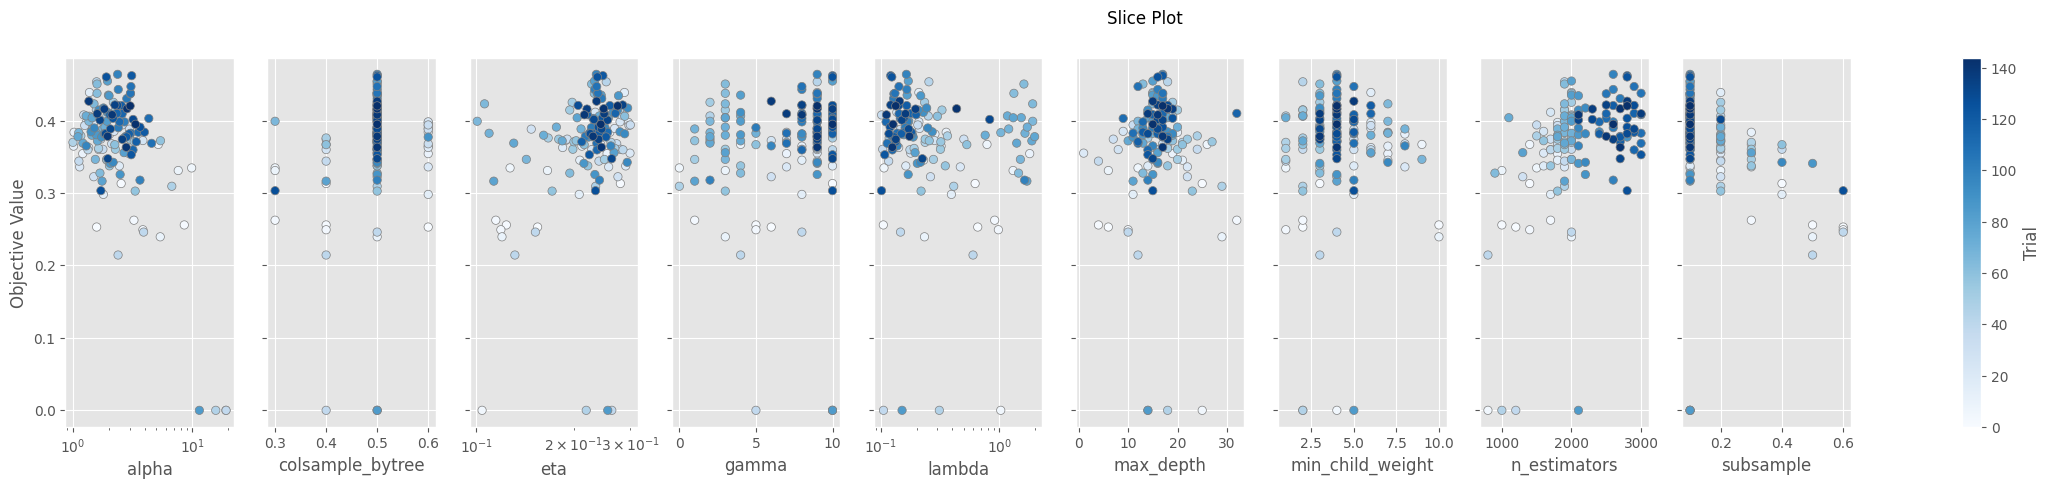

In [104]:
# study identifiers
study_name = "xgb_study_gte_cme_suicideThOnly"
storage_name = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend("./optuna_journal_storage_xgb_gte_cme_suicideThOnly.log")
)

# init classifier
clf = xgb.XGBClassifier


# tuning directory for model
if not os.path.exists(XGB_TUNING_DIR):
    os.makedirs(XGB_TUNING_DIR)

# check for a saved sampler
try:
    sampler = pickle.load(open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
except (OSError, IOError) as e:
    sampler = TPESampler(seed=SEED)

pruner = MedianPruner()
    
# create study and optimize
study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

study.optimize(lambda trial: TreeObjective(trial, seed=SEED, 
                                           X_train=gte_cme_train, X_val=gte_cme_val,
                                           y_train=y_train_suiTh, y_val=y_val_suiTh, algo=clf), 
               n_trials=200, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


with open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

# saving charts from study
try:
    save_study_charts(study=study, study_name=study_name, dir=XGB_TUNING_DIR)
except Exception as e:
    print(f"Error when trying to save charts: {e}")